In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)
pd.set_option('display.float_format', '{:.2f}'.format)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from pipelines import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prettytable import PrettyTable


In [2]:
path = '/Users/tristangarcia/Desktop/hp-pred/data/'

test = pd.read_csv(f'{path}wa/wa_test.csv')

preprocess = pickle.load(open(f'{path}preprocessing_pipeline.pkl', 'rb'))

rf_model = pickle.load(open(f'{path}rfmodel.pkl', 'rb'))
xgb_model = pickle.load(open(f'{path}xgbmodel.pkl', 'rb'))

In [3]:
test = preprocess.transform(test)

### Split

In [4]:
x_test = test.drop(columns=['soldPrice'])
y_test = test['soldPrice']

# Utility Functions

In [5]:
def calculate_regression_metrics(y_true, y_pred):
    """
    Calculate regression metrics: MSE, RMSE, MAE, MAPE, and R-squared.
    """
    mse = round(mean_squared_error(y_true, y_pred), 4)
    rmse = round(np.sqrt(mse), 4)  # Calculate RMSE
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    mape = round(np.mean(np.abs((y_true - y_pred) / (y_true))) * 100, 4)
    r2 = round(r2_score(y_true, y_pred), 4)
    return mse, rmse, mae, mape, r2

def print_regression_results_table(test_results, model_name):
    """
    Print regression results in a PrettyTable for train and test datasets.
    """
    table = PrettyTable()
    table.field_names = ['Dataset', 'Model', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
    
    # Unpack train and test results
    test_mse, test_rmse, test_mae, test_mape, test_r2 = test_results
    
    table.add_row(['Test', model_name, test_mse, test_rmse, test_mae, test_mape, test_r2])
    print(table)

def plot_predictions(y_true_test, y_pred_test):
    """
    Plot predictions vs. actual values for test dataset using a scatter plot and a line showing perfect predictions.
    """
    plt.figure(figsize=(8, 6))
    
    sns.scatterplot(x=y_true_test, y=y_pred_test)
    
    # Plotting the identity line
    plt.plot([min(y_true_test), max(y_true_test)], [min(y_true_test), max(y_true_test)], 'r--')
    
    plt.title("Test: Actual vs. Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

def evaluate_model(model, x_test, y_test, model_name):
    """ 
    Evaluate regression model performance on train and test datasets.
    """
    # Prediction
    y_test_pred = model.predict(x_test)
        
    # Calculate metrics for test set
    test_results = calculate_regression_metrics(y_test, y_test_pred)
    
    # Print results in a table
    print_regression_results_table(test_results, model_name)
    
    # Plot predictions vs. actual
    plot_predictions(y_test, y_test_pred)
    
    return y_test_pred

# Evaluation

### Random Forest

+---------+---------------+--------+--------+--------+--------+--------+
| Dataset |     Model     |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+---------------+--------+--------+--------+--------+--------+
|   Test  | Random Forest | 0.0069 | 0.0831 | 0.0592 | 1.0104 | 0.8537 |
+---------+---------------+--------+--------+--------+--------+--------+


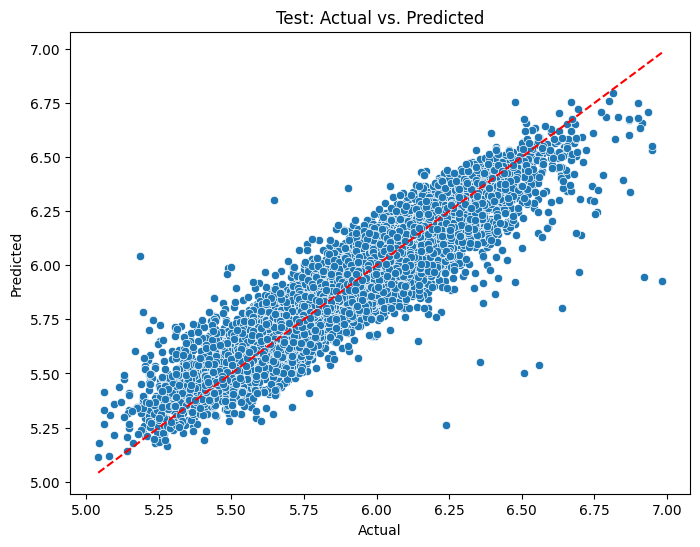

In [6]:
rf_pred = evaluate_model(rf_model, x_test, y_test, 'Random Forest')

### XGBoost

+---------+---------+--------+--------+--------+--------+--------+
| Dataset |  Model  |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+---------+--------+--------+--------+--------+--------+
|   Test  | XGBoost | 0.0069 | 0.0831 | 0.0604 | 1.0314 | 0.8531 |
+---------+---------+--------+--------+--------+--------+--------+


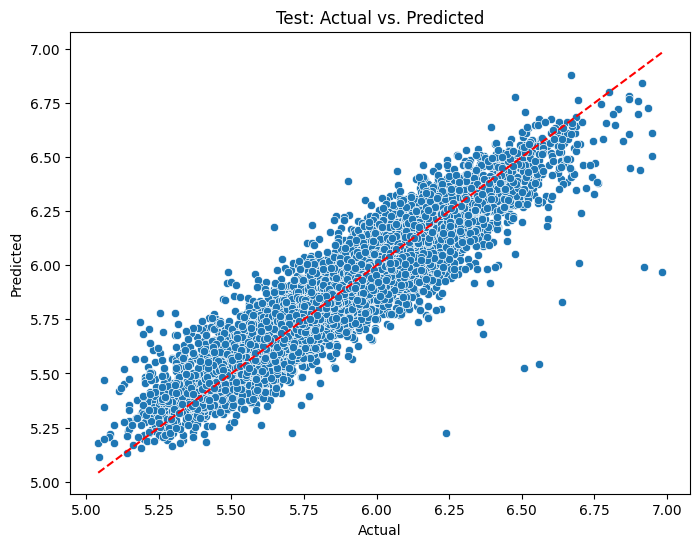

In [7]:
xgb_pred = evaluate_model(xgb_model, x_test, y_test, 'XGBoost')

The random forest model is only slightly better than the xgboost model due to the lower MAE

# Residual Analysis

<Axes: xlabel='soldPrice', ylabel='Count'>

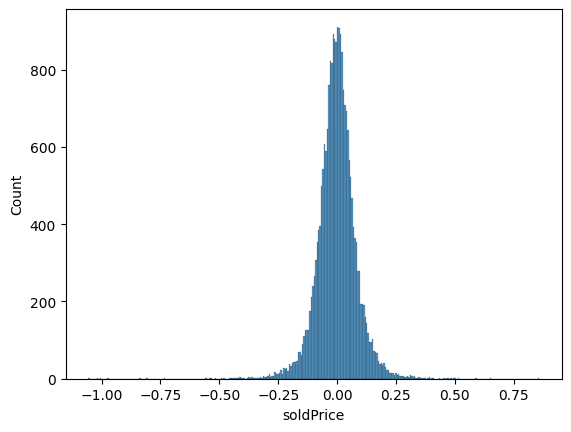

In [8]:
sns.histplot(rf_pred-y_test)

The residuals are normally distributed

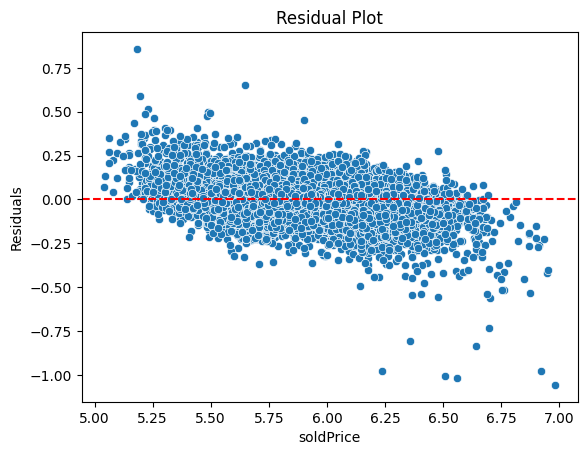

In [9]:
sns.scatterplot(y=(rf_pred-y_test), x=(y_test))
plt.axhline(0, color='red', linestyle='--')  # horizontal line at y=0

plt.xlabel('soldPrice')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The residual plot seems to follow a negative linear pattern. It seems like the model is overpredicting values when soldPrice is less than 5.5 and underpredicting when soldPrice is greater than 6.5. This linear pattern could be due to the influence of outliers in the fitted values. We will repredict a filtered version of the validation set (excluding outliers) to recheck the residual plot

In [10]:
# Calculating IQR
Q1 = test['soldPrice'].quantile(0.25)
Q3 = test['soldPrice'].quantile(0.75)
IQR = Q3 - Q1

# Defining outliers as those beyond 1.5 times the IQR from the Q1 or Q3
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the DataFrame to remove outliers
filtered_test = test[(test['soldPrice'] >= lower_bound) & (test['soldPrice'] <= upper_bound)]

x2_test = filtered_test.drop(columns=['soldPrice'])
y2_test = filtered_test['soldPrice']

filtered_predicted = rf_model.predict(x2_test) 

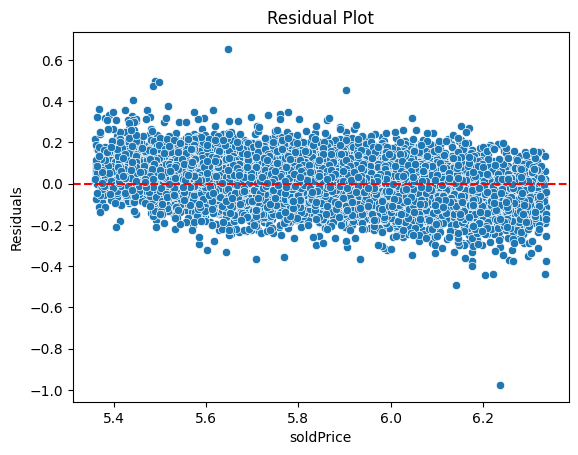

In [11]:
sns.scatterplot(y=(filtered_predicted - y2_test), x=(y2_test))
plt.axhline(0, color='red', linestyle='--')  # horizontal line at y=0

plt.xlabel('soldPrice')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Removing outliers from the fitted values has reduced the negative linear pattern of the residual plot, thereby confirming that the shape was due to the outlier in the sets for prediction

# Prediction Error Ranges

We will now categorise the predictions and calcaulte the mean absolute error to get an understanding of the error in certain ranges of predictions

In [12]:
df = pd.DataFrame({
    'y_test': 10**y2_test,
    'rf_pred': 10**filtered_predicted
})

# Categorize the data into bins of hundred thousands
df['price_range'] = pd.cut(df['rf_pred'], bins=np.arange(0, df['rf_pred'].max() + 100000, 100000), right=False)

# Calculate the mean absolute error within each category
df['abs_error'] = np.abs(df['y_test'] - df['rf_pred'])
mean_abs_errors_by_range = df.groupby('price_range', observed=True)['abs_error'].mean()

In [13]:
mean_abs_errors_by_range

price_range
[100000.0, 200000.0)     227259.29
[200000.0, 300000.0)      45182.65
[300000.0, 400000.0)      55203.09
[400000.0, 500000.0)      61184.11
[500000.0, 600000.0)      64640.84
[600000.0, 700000.0)      74556.75
[700000.0, 800000.0)      92376.30
[800000.0, 900000.0)     104943.59
[900000.0, 1000000.0)    128815.93
[1000000.0, 1100000.0)   147133.34
[1100000.0, 1200000.0)   163070.48
[1200000.0, 1300000.0)   196262.51
[1300000.0, 1400000.0)   211986.39
[1400000.0, 1500000.0)   212519.44
[1500000.0, 1600000.0)   222559.87
[1600000.0, 1700000.0)   253628.31
[1700000.0, 1800000.0)   243462.47
[1800000.0, 1900000.0)   226563.78
[1900000.0, 2000000.0)   265107.03
[2000000.0, 2100000.0)   308423.43
[2100000.0, 2200000.0)   380219.06
[2200000.0, 2300000.0)   362080.76
[2300000.0, 2400000.0)   597992.64
[2400000.0, 2500000.0)   531722.02
[2500000.0, 2600000.0)   686338.37
[2600000.0, 2700000.0)   797031.32
[2700000.0, 2800000.0)   966024.21
[2800000.0, 2900000.0)   811052.99
[2900000

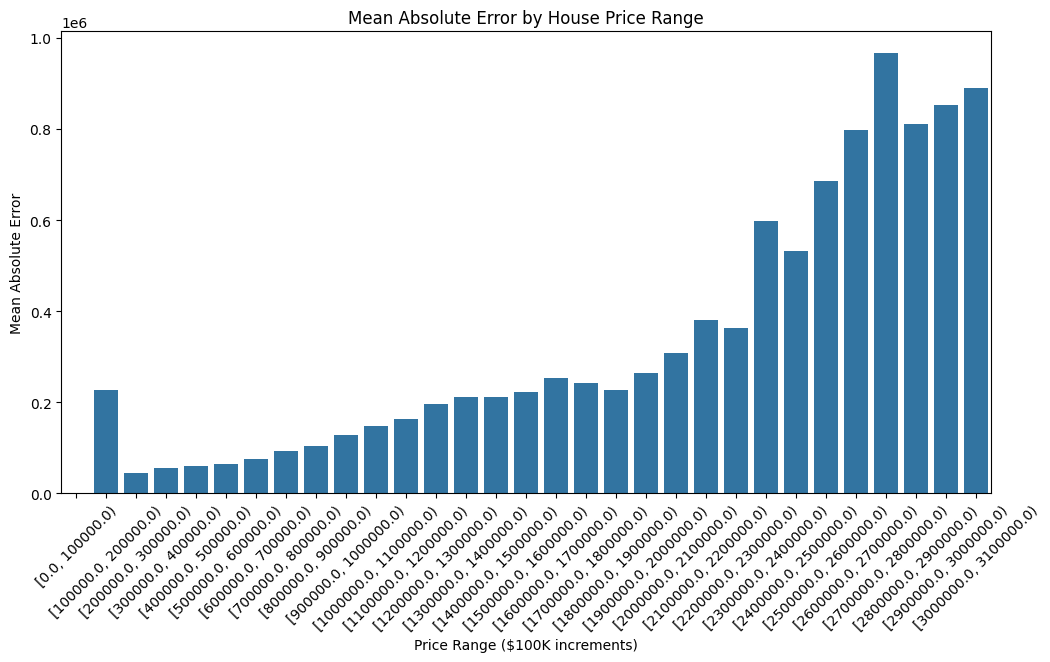

In [14]:
mean_abs_errors_by_range_df = mean_abs_errors_by_range.reset_index()
mean_abs_errors_by_range_df.columns = ['price_range', 'abs_error']  

plt.figure(figsize=(12, 6))
sns.barplot(x='price_range', y='abs_error', data=mean_abs_errors_by_range_df)

plt.title('Mean Absolute Error by House Price Range')
plt.xlabel('Price Range ($100K increments)')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45) 

plt.show()

The bar chart illustrates a gradual increase in the mean absolute error as the price range escalates, with a noticeable, more rapid increase starting from the 800,000 to 900,000 range onwards. This trend indicates larger prediction errors in more expensive homes. 